In [1]:
import numpy as np
import pandas as pd
import json
from dscribe.descriptors import CoulombMatrix
from ase import Atoms
import matplotlib.pyplot as plt


test = pd.read_json('data/test.json')
train = pd.read_json('data/train.json')
## Transform atoms entry to ASE atoms object
train.atoms = train.atoms.apply(lambda x: Atoms(**x)) # OBS This one is important!
test.atoms = test.atoms.apply(lambda x: Atoms(**x))

species = []
number_of_atoms = []
atomic_numbers = []
for atom in pd.concat([train.atoms,test.atoms]):
    species = list(set(species+atom.get_chemical_symbols()))
    atomic_numbers = list(set(atomic_numbers+list(atom.get_atomic_numbers())))
    number_of_atoms.append(len(atom))

max_number_of_atoms = np.max(number_of_atoms)
min_atomic_number = np.min(atomic_numbers)
max_atomic_number = np.max(atomic_numbers)

In [2]:
from dscribe.descriptors import SOAP,CoulombMatrix

r_cut = 6
n_max = 2
l_max = 2

# Setting up the SOAP descriptor
soap = SOAP(
    species=species,
    periodic=True,
    r_cut=r_cut,
    n_max=n_max,
    l_max=l_max,
    average = 'inner'
)

In [3]:
soap_mats = np.zeros((len(train.atoms),23250))
for i,atoms in enumerate(train.atoms):
    if i%1000 == 1:
        print(i)
    soap_mats[i,:] = soap.create(atoms)

1
1001
2001
3001
4001
5001
6001
7001


In [4]:
X = pd.DataFrame(data = soap_mats, index=train.id)
y = train['hform']

In [5]:
from sklearn.decomposition import PCA

n_comp_PCA = 200

pca = PCA(n_components = n_comp_PCA).fit(X)
X_PCA = pca.transform(X)
print("With {} PCA components {var:0.4f}% of the variance is explained".format(n_comp_PCA, var = 100*np.sum(pca.explained_variance_ratio_)))

With 200 PCA components 93.8856% of the variance is explained


In [10]:
np.shape(X_test)

(1600, 200)

In [8]:
from sklearn.model_selection import train_test_split

X_train,X_test,y_train,y_test = train_test_split(X_PCA,y,test_size=0.2,random_state=251)

In [ ]:
from sklearn import ensemble
from sklearn.metrics import mean_squared_error as mse

def rmse(y_true, y_pred):
    return np.sqrt(mse(y_true, y_pred))

params = {
        "n_estimators": 400,
        "max_depth": 7,
        "min_samples_split": 7,
        "learning_rate": 0.1,
        "loss": "squared_error",
    }

reg = ensemble.GradientBoostingRegressor(**params)
reg.fit(X_train, y_train)
train_prediction = reg.predict(X_train)
test_prediction = reg.predict(X_test)
print('Train RMSE = {:.2f}'.format(rmse(y_train,train_prediction)))
print('Test RMSE = {:.2f}'.format(rmse(y_test,test_prediction)))

Learning = 7999 Train RMSE = 0.01
Learning = 7999 Test RMSE = 0.26


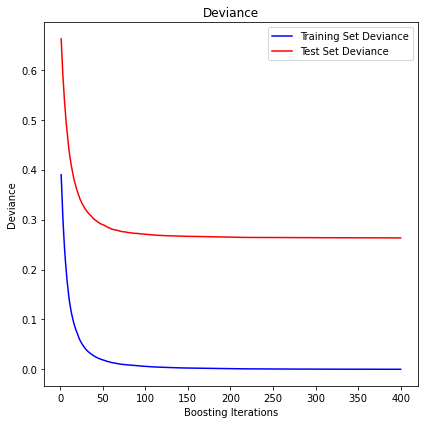

In [14]:
test_score = np.zeros((params["n_estimators"],), dtype=np.float64)
for i, y_pred in enumerate(reg.staged_predict(X_test)):
    test_score[i] = rmse(y_test, y_pred)

fig = plt.figure(figsize=(6, 6))
plt.subplot(1, 1, 1)
plt.title("Deviance")
plt.plot(
    np.arange(params["n_estimators"]) + 1,
    reg.train_score_,
    "b-",
    label="Training Set Deviance",
)
plt.plot(
    np.arange(params["n_estimators"]) + 1, test_score, "r-", label="Test Set Deviance"
)
plt.legend(loc="upper right")
plt.xlabel("Boosting Iterations")
plt.ylabel("Deviance")
fig.tight_layout()
plt.show()
